In [1]:
# import your kaggle token!!
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"junhyungkang","key":"791d7f7fae78a39d11046886fe9a2bb5"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d scolianni/mnistasjpg

 95% 65.0M/68.4M [00:02<00:00, 20.4MB/s]
100% 68.4M/68.4M [00:02<00:00, 29.1MB/s]


In [4]:
import zipfile
         
zipfile.ZipFile('mnistasjpg.zip').extractall()
zipfile.ZipFile('mnistasjpg.zip').close()

In [43]:
import os
import random

tr = []
for path, _, files in os.walk('trainingSet/trainingSet'):
    for img in files:
        tr_path = os.path.join(path, img)
        tr.append(tr_path)

random.shuffle(tr)

test = []
for path, _, files in os.walk('testSet/testSet'):
    for img in files:
        test_path = os.path.join(path, img)
        test.append(test_path)

ratio = 0.9
int(len(tr) * 0.9)
val = tr[int(len(tr) * 0.9):]
tr = tr[:int(len(tr) * 0.9)]
test = test

print(len(tr))
print(len(val))
print(len(test))

37800
4200
28000


In [6]:
import cv2

# image shape 확인
sample_img = cv2.imread(tr[0])
print(sample_img.shape)

(28, 28, 3)


In [7]:
import cv2
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

class MnistDataSet(Dataset):
    def __init__(self, paths):
        self.paths = paths
        labels = []
        for i in paths:
            labels.append(int(i.split('/')[-2]))
        self.labels = labels
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        img = img.transpose(2, 0, 1).astype(np.float)
        label = np.asarray(self.labels[index])
        label = torch.from_numpy(label)
        
        return img, label

In [8]:
class MnistDataSet_test(Dataset):
    def __init__(self, paths):
        self.paths = paths
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        img = img.transpose(2, 0, 1).astype(np.float)
        
        return img

In [44]:
tr_dataset = MnistDataSet(tr)
val_dataset = MnistDataSet(val)
test_dataset = MnistDataSet_test(test)

In [50]:
tr_dataloader = DataLoader(tr_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.float())))  # output = 6, 12
        x = self.pool(F.relu(self.conv2(x)))  # output = 16, 4
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
import torch.optim as optim

model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    for i, data in enumerate(tr_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        # print('tr_labels: ', labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    total = 0
    correct = 0
    for i, data in enumerate(val_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        # print('predicted: ', predicted)
        # print('val_labels: ', labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('[%d epoch] Accuracy on the validation images: %d %%' %(epoch + 1, 100 * correct / total))
    print('[%d epoch] loss: %f' %(epoch + 1, loss))

[1 epoch] Accuracy on the validation images: 32 %
[1 epoch] loss: 1.992804
[2 epoch] Accuracy on the validation images: 58 %
[2 epoch] loss: 1.420710
[3 epoch] Accuracy on the validation images: 75 %
[3 epoch] loss: 0.912054
[4 epoch] Accuracy on the validation images: 82 %
[4 epoch] loss: 0.612868
[5 epoch] Accuracy on the validation images: 86 %
[5 epoch] loss: 0.542027
[6 epoch] Accuracy on the validation images: 87 %
[6 epoch] loss: 0.393151
[7 epoch] Accuracy on the validation images: 89 %
[7 epoch] loss: 0.379739
[8 epoch] Accuracy on the validation images: 90 %
[8 epoch] loss: 0.357836
[9 epoch] Accuracy on the validation images: 91 %
[9 epoch] loss: 0.286812
[10 epoch] Accuracy on the validation images: 91 %
[10 epoch] loss: 0.289867
[11 epoch] Accuracy on the validation images: 92 %
[11 epoch] loss: 0.272617
[12 epoch] Accuracy on the validation images: 92 %
[12 epoch] loss: 0.286756
[13 epoch] Accuracy on the validation images: 93 %
[13 epoch] loss: 0.199238
[14 epoch] Accura

tensor(6)


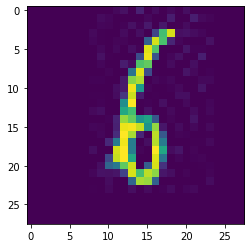

In [55]:
from matplotlib.pyplot import imshow
from PIL import Image

sample_no = random.randrange(0, int(28000/512))

for i, data in enumerate(test_dataloader, 0):
    inputs = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    if i == sample_no:
        print(predicted[0])
        %matplotlib inline
        sample_img = Image.open(test[i*512], 'r')
        imshow(np.asarray(sample_img))
    